# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.
Our target accuracy is 70%, but any accuracy over 50% is a great start.
Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [1]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

CUDA available: True
CUDA version: 12.4
GPU: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Create training set and define training dataloader
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# Create test set and define test dataloader
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# The 10 classes in the dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(classes[labels[i]])
    
        image = images[i].numpy()
        plt.imshow(image.T)
        plt.show()

Training set size: 50000
Test set size: 10000
Number of classes: 10

Image batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])
Image data type: torch.float32
Image value range: [-2.429, 2.754]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.3635254].


car


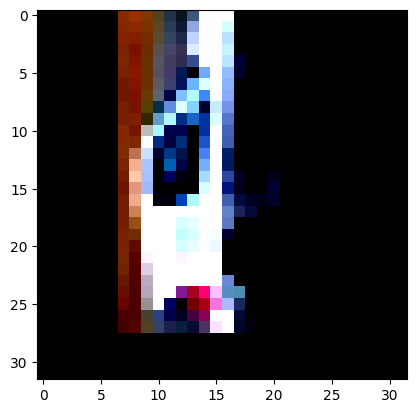

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.2269535].


cat


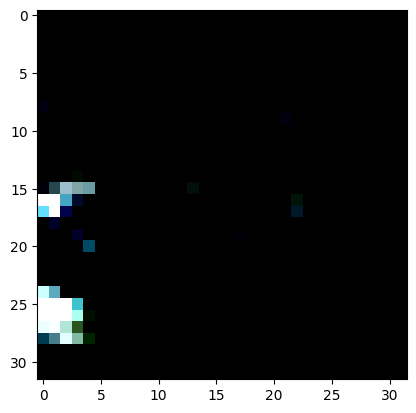

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.734221].


truck


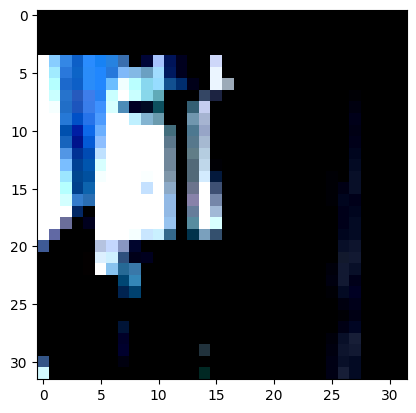

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.461077].


bird


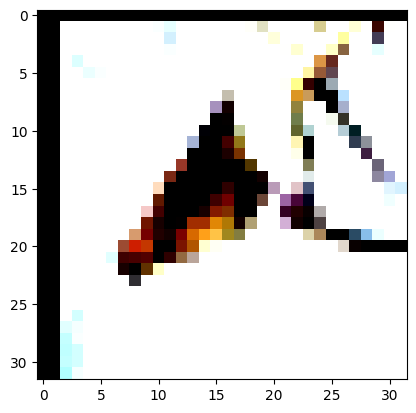

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.4290657..2.2426991].


dog


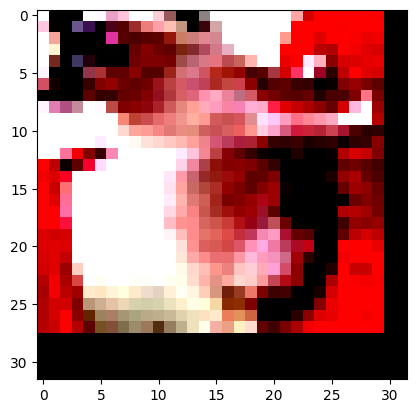

In [5]:
# Explore data
print(f"Training set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")
print(f"Number of classes: {len(classes)}")

# Get a sample batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"\nImage batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image data type: {images.dtype}")
print(f"Image value range: [{images.min():.3f}, {images.max():.3f}]")

# Show some sample images
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

In [6]:
class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)
        self.bn4 = nn.BatchNorm2d(512)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second conv block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third conv block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Fourth conv block
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        # Flatten
        x = x.view(-1, 512 * 2 * 2)
        
        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

# Instantiate the model
model = CIFAR10Net()
print(model)

CIFAR10Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [7]:
# Loss function - CrossEntropyLoss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer - Adam optimizer with learning rate scheduling
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

Using device: cuda


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [8]:
# Training parameters
num_epochs = 20
train_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Print loss every 250 batches
        if (batch_idx + 1) % 250 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # Update learning rate
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}] completed, Average Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')
    print('-' * 60)

print('Training completed!')

Epoch [1/20], Batch [250/391], Loss: 1.5195
Epoch [1/20] completed, Average Loss: 1.6139, LR: 0.001000
------------------------------------------------------------
Epoch [2/20], Batch [250/391], Loss: 1.2728
Epoch [2/20] completed, Average Loss: 1.2136, LR: 0.001000
------------------------------------------------------------
Epoch [3/20], Batch [250/391], Loss: 1.1062
Epoch [3/20] completed, Average Loss: 1.0328, LR: 0.001000
------------------------------------------------------------
Epoch [4/20], Batch [250/391], Loss: 0.8376
Epoch [4/20] completed, Average Loss: 0.9290, LR: 0.001000
------------------------------------------------------------
Epoch [5/20], Batch [250/391], Loss: 0.8279
Epoch [5/20] completed, Average Loss: 0.8425, LR: 0.001000
------------------------------------------------------------
Epoch [6/20], Batch [250/391], Loss: 0.9877
Epoch [6/20] completed, Average Loss: 0.7764, LR: 0.001000
------------------------------------------------------------
Epoch [7/20], Ba

Plot the training loss (and validation loss/accuracy, if recorded).

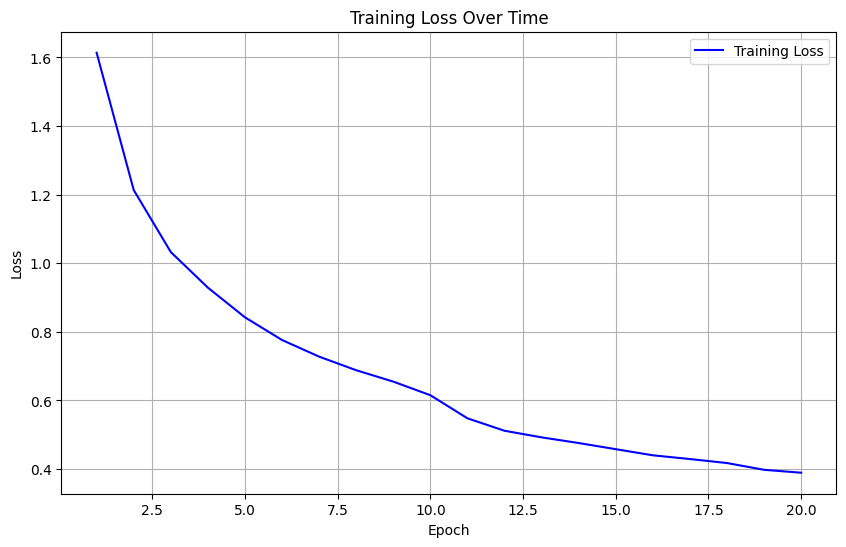

In [9]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [10]:
# Test the model
model.eval()
correct = 0
total = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Per-class accuracy
        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Overall accuracy
accuracy = 100 * correct / total
print(f'Overall Test Accuracy: {accuracy:.2f}%')

# Per-class accuracy
print('\nPer-class accuracy:')
for i in range(10):
    if class_total[i] > 0:
        print(f'{classes[i]:10s}: {100 * class_correct[i] / class_total[i]:.2f}%')
    else:
        print(f'{classes[i]:10s}: N/A')

Overall Test Accuracy: 84.91%

Per-class accuracy:
plane     : 89.00%
car       : 95.20%
bird      : 69.00%
cat       : 65.60%
deer      : 81.10%
dog       : 86.10%
frog      : 87.90%
horse     : 91.50%
ship      : 93.10%
truck     : 90.60%


## Saving your model
Using `torch.save`, save your model for future loading.

In [11]:
# Save the model
model_path = 'cifar10_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'loss': train_losses[-1],
    'accuracy': accuracy
}, model_path)

print(f'Model saved to {model_path}')

# Example of how to load the model later:
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

Model saved to cifar10_model.pth


## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

**Recommendation: Build (with conditions)**

Based on the evaluation results showing **84.91% test accuracy** (significantly exceeding the 70% target), I recommend **building a custom solution** for this CIFAR-10 classification task, with the following considerations:

**Reasons to Build:**
1. **Performance Achievement**: The custom model achieved 84.91% accuracy, which exceeds the 70% target and demonstrates that a custom solution can meet the requirements effectively.

2. **Cost-Effectiveness**: Building a custom model avoids ongoing API costs, per-request fees, and subscription costs associated with commercial solutions. For high-volume applications, this can result in significant cost savings over time.

3. **Data Privacy & Control**: A custom-built model allows complete control over data processing, ensuring sensitive images never leave your infrastructure. This is crucial for industries with strict data privacy requirements (healthcare, finance, etc.).

4. **Customization**: The model architecture can be specifically tuned for the CIFAR-10 dataset characteristics. The current architecture (4 convolutional layers with batch normalization, dropout, and data augmentation) is well-suited for this task.

5. **No Vendor Lock-in**: Building your own solution eliminates dependency on external services, avoiding potential service disruptions, API changes, or vendor discontinuation.

**Considerations & Caveats:**
1. **Maintenance Overhead**: The model requires ongoing maintenance, monitoring, and potential retraining as data distributions change. This requires ML engineering expertise.

2. **Initial Development Time**: While this model was successfully built, production deployment requires additional work (model serving, monitoring, CI/CD pipelines).

3. **When to Consider Buying**: If the organization lacks ML expertise, has low classification volume, or needs immediate deployment without development time, a commercial API (like Google Cloud Vision, AWS Rekognition, or Azure Computer Vision) might be more appropriate.

**Conclusion**: Given the successful 84.91% accuracy achievement and the specific requirements of CIFAR-10 classification, **building is the recommended approach** for organizations with ML capabilities. However, for organizations without ML expertise or with urgent deployment needs, a hybrid approach (buy initially, build later) could be considered.
